# Importing Modules and Defining Functions

In [25]:
import re
import sys
import requests
import pandas as pd
from json import loads
import matplotlib.pyplot as plt

def httpsReq(requestAddr):

    #Making the API Request
    # print(f'Making API Call to: {requestAddr}')
    response = requests.get(requestAddr)
    if response.status_code == 200:
        pass
    elif response.status_code != 200:
        print(f'{response.status_code} - API Request {requestAddr} Failed')
        KeyboardInterrupt

    #Converting JSON to Dict and Parsing API Data into a Dataframe
    dict = loads(response.text)

    return dict

# Requesting Game History via Chess.com API
### We need to stage our api request to transform into a dataframe:
- The api request address only returns the games for the selected month and year
- There we must pull down our archive histotry and loop through the api requests to return data for each month

In [43]:
#Retrieveing Archive of My Entire Chess.com History
player = 'filiplivancic'
dict = httpsReq(f'https://api.chess.com/pub/player/{player}/games/archives')
print(f'API Request for Monthly API Endpoints Successful')
archive = (dict['archives'])
archive[:5]

API Request for Monthly API Endpoints Successful


['https://api.chess.com/pub/player/filiplivancic/games/2019/05',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/07',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/08',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/09',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/10']

## Looping through every archived month, pulling all games and placing into list

In [3]:
list = []
print('Extracting Entire Game History Through All Monthly API Endpoints')
for request in archive:
    dict_arch = httpsReq(request)
    list.append(dict_arch)
print(f'API Request Successful and Appended all the dictionaries together')

Extracting Entire Game History Through All Monthly API Endpoints
API Request Successful and Appended all the dictionaries together


## Unpacking List of Games

In [139]:
game_list = []
print('Transforming JSON data into a dataframe')
for month in list: 
    month_of_games = month['games']
    for game in month_of_games: game_list.append(game)
df = pd.DataFrame(game_list)
df.head(3)

Transforming JSON data into a dataframe


,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,white,black,accuracies
0,https://www.chess.com/game/live/3668045802,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902183,True,mC3Nbs5Qlt!TcMZJCKQKtB7RfH6Zdm86BKRzKT0THOzjOX...,fd899364-2d30-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,blitz,chess,"{'rating': 804, 'result': 'timeout', '@id': 'h...","{'rating': 973, 'result': 'win', '@id': 'https...",NaN
1,https://www.chess.com/game/live/3668084540,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902975,True,lB!Tbs5QBJQKnDKEpxEVmC0SCKT!sC9zclWGkA7FowF0iq...,a090dbf8-2d36-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,blitz,chess,"{'rating': 797, 'result': 'checkmated', '@id':...","{'rating': 925, 'result': 'win', '@id': 'https...",NaN
2,https://www.chess.com/game/live/3668146117,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556903918,True,ltWGcM2Ugv4OmCYItBIAfAOPbsPQBJQAvKAYdvZRv1,96bfa632-2d3f-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,blitz,chess,"{'rating': 990, 'result': 'win', '@id': 'https...","{'rating': 775, 'result': 'checkmated', '@id':...",NaN


## Unpacking Nested white/black dictionaries -- Creating Derived Data For Wins/Losses

In [140]:
# Checking contents of white/black
print('Unpacking the ratings data from all individual games')
result_list = []
for i in range(df.shape[0]):

    #Find each dictionary set for white and black
    white_result = df.iloc[i,df.columns.get_loc('white')]
    black_result = df.iloc[i,df.columns.get_loc('black')]

    #Search for my username, if there is a match, we will append it to the results list
    if white_result['username'] == 'filiplivancic':
        result_list.append(white_result)
    else:
        result_list.append(black_result)
    
#Performing check to see if length of list matches the size of the dataframe
print(df.shape[0],len(result_list))

#Transforming results into output dataframe and dropping irrelevant columns
result_df = pd.DataFrame(result_list)
result_df.drop(columns={'@id','username','uuid'}, inplace=True)

#Adding extra col to group the varieties of losses and draws into a parent catagory
result_df['win/loss'] = ''
for i in range(result_df.shape[0]):
    res = result_df.iloc[i,result_df.columns.get_loc('result')]
    if res == 'win':
        result_df.iloc[i,result_df.columns.get_loc('win/loss')] = 'win'
    if res == 'timevsinsufficient' or res == 'stalemate':
        result_df.iloc[i,result_df.columns.get_loc('win/loss')] = 'draw'
    if res != 'win' and res != 'timevsinsufficient' and res != 'stalemate':
        result_df.iloc[i,result_df.columns.get_loc('win/loss')] = 'loss'
# set(result_df['result'])
# result_df.loc[result_df['win/loss'] == 'draw']
result_df


Unpacking the ratings data from all individual games
2242 2242


,rating,result,win/loss
0,804,timeout,loss
1,925,win,win
2,990,win,win
3,897,resigned,loss
4,828,resigned,loss
...,...,...,...
2237,1023,win,win
2238,1012,resigned,loss
2239,1021,win,win
2240,1031,win,win


## Concatenating Result Onto The Main Dataframe

In [141]:
print('Appending the unpacked data onto the main dataframe')
df_rating = pd.concat([df,result_df],axis=1)
df_rating.head(3)

Appending the unpacked data onto the main dataframe


,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,white,black,accuracies,rating,result,win/loss
0,https://www.chess.com/game/live/3668045802,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902183,True,mC3Nbs5Qlt!TcMZJCKQKtB7RfH6Zdm86BKRzKT0THOzjOX...,fd899364-2d30-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,blitz,chess,"{'rating': 804, 'result': 'timeout', '@id': 'h...","{'rating': 973, 'result': 'win', '@id': 'https...",NaN,804,timeout,loss
1,https://www.chess.com/game/live/3668084540,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902975,True,lB!Tbs5QBJQKnDKEpxEVmC0SCKT!sC9zclWGkA7FowF0iq...,a090dbf8-2d36-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,blitz,chess,"{'rating': 797, 'result': 'checkmated', '@id':...","{'rating': 925, 'result': 'win', '@id': 'https...",NaN,925,win,win
2,https://www.chess.com/game/live/3668146117,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556903918,True,ltWGcM2Ugv4OmCYItBIAfAOPbsPQBJQAvKAYdvZRv1,96bfa632-2d3f-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,blitz,chess,"{'rating': 990, 'result': 'win', '@id': 'https...","{'rating': 775, 'result': 'checkmated', '@id':...",NaN,990,win,win


## Extracting More Metadata From The Chess Games

In [148]:
date_list = []
opening_list = []
quoted = re.compile('"[^"]*"')

for i in range(df_rating.shape[0]):
    
    #Splitting the metadata by each new line
    meta_data = df.iloc[i,df.columns.get_loc('pgn')].splitlines(False)
    
    #Appending dates into the list by string index 
    # date_list.append(meta_data[2][7:17])
    for date in quoted.findall(meta_data[2]): date_list.append(date)

    #Appending openings by retrieveing double quote contents
    for opening in quoted.findall(meta_data[10]): opening_list.append(opening)


## Adding Metadata as New Columns in the DataFrame

In [149]:
df_rating['Date'] = date_list
df_rating['Opening'] = opening_list
df_rating.head(5)

,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,white,black,accuracies,rating,result,win/loss,Date,Opening
0,https://www.chess.com/game/live/3668045802,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902183,True,mC3Nbs5Qlt!TcMZJCKQKtB7RfH6Zdm86BKRzKT0THOzjOX...,fd899364-2d30-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,blitz,chess,"{'rating': 804, 'result': 'timeout', '@id': 'h...","{'rating': 973, 'result': 'win', '@id': 'https...",NaN,804,timeout,loss,"""2019.05.03""","""https://www.chess.com/openings/Kings-Pawn-Ope..."
1,https://www.chess.com/game/live/3668084540,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902975,True,lB!Tbs5QBJQKnDKEpxEVmC0SCKT!sC9zclWGkA7FowF0iq...,a090dbf8-2d36-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,blitz,chess,"{'rating': 797, 'result': 'checkmated', '@id':...","{'rating': 925, 'result': 'win', '@id': 'https...",NaN,925,win,win,"""2019.05.03""","""https://www.chess.com/openings/Indian-Game-2...."
2,https://www.chess.com/game/live/3668146117,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556903918,True,ltWGcM2Ugv4OmCYItBIAfAOPbsPQBJQAvKAYdvZRv1,96bfa632-2d3f-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,blitz,chess,"{'rating': 990, 'result': 'win', '@id': 'https...","{'rating': 775, 'result': 'checkmated', '@id':...",NaN,990,win,win,"""2019.05.03""","""https://www.chess.com/openings/Mieses-Opening"""
3,https://www.chess.com/game/live/3668401579,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556910410,True,mC2UfA!Tlt92gv5QbsZRvMQzM17Z1?2?iqZyAryGeg6Env...,c339e96e-2d64-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,r3k2b/ppp1p2p/1q1p1np1/8/4P1b1/PBNP1P2/1PQ3PP/...,blitz,chess,"{'rating': 930, 'result': 'win', '@id': 'https...","{'rating': 897, 'result': 'resigned', '@id': '...",NaN,897,resigned,loss,"""2019.05.03""","""https://www.chess.com/openings/Modern-Defense..."
4,https://www.chess.com/game/live/3668434614,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556911325,True,mCYQnv2UlB3Now!Tks5OjzZRfOXOiy45yGNFcMFwMT0Tdl...,920fe7bc-2d69-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1r3r2/p4p2/p1pp1kp1/P7/1P1PP3/2P3PR/3Nb2Q/R3K3...,blitz,chess,"{'rating': 908, 'result': 'win', '@id': 'https...","{'rating': 828, 'result': 'resigned', '@id': '...",NaN,828,resigned,loss,"""2019.05.03""","""https://www.chess.com/openings/Caro-Kann-Defe..."


## Cleaning Dates and String Data

In [150]:
# Replacing the double quotes in string
df_rating['Date'] = df_rating['Date'].str.replace('"','')
df_rating['Opening'] = df_rating['Opening'].str.replace('"','')

# Converting to Datetime Format
df_rating['Date'] = pd.to_datetime(df_rating['Date'])

# Removing https prefix from opening column
df_rating['Opening'] = df_rating['Opening'].str.replace('https://www.chess.com/openings/','')
df_rating['Opening'] = df_rating['Opening'].str.replace('-',' ')
df_rating.head(5)

C:\Users\FILIPL~1.COM\AppData\Local\Temp/ipykernel_3960/1891184434.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_rating['Opening'] = df_rating['Opening'].str.replace('https://www.chess.com/openings/','')


,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,white,black,accuracies,rating,result,win/loss,Date,Opening
0,https://www.chess.com/game/live/3668045802,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902183,True,mC3Nbs5Qlt!TcMZJCKQKtB7RfH6Zdm86BKRzKT0THOzjOX...,fd899364-2d30-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,blitz,chess,"{'rating': 804, 'result': 'timeout', '@id': 'h...","{'rating': 973, 'result': 'win', '@id': 'https...",NaN,804,timeout,loss,2019-05-03,Kings Pawn Opening Goldsmith Defense
1,https://www.chess.com/game/live/3668084540,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902975,True,lB!Tbs5QBJQKnDKEpxEVmC0SCKT!sC9zclWGkA7FowF0iq...,a090dbf8-2d36-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,blitz,chess,"{'rating': 797, 'result': 'checkmated', '@id':...","{'rating': 925, 'result': 'win', '@id': 'https...",NaN,925,win,win,2019-05-03,Indian Game 2.Nc3
2,https://www.chess.com/game/live/3668146117,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556903918,True,ltWGcM2Ugv4OmCYItBIAfAOPbsPQBJQAvKAYdvZRv1,96bfa632-2d3f-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,blitz,chess,"{'rating': 990, 'result': 'win', '@id': 'https...","{'rating': 775, 'result': 'checkmated', '@id':...",NaN,990,win,win,2019-05-03,Mieses Opening
3,https://www.chess.com/game/live/3668401579,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556910410,True,mC2UfA!Tlt92gv5QbsZRvMQzM17Z1?2?iqZyAryGeg6Env...,c339e96e-2d64-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,r3k2b/ppp1p2p/1q1p1np1/8/4P1b1/PBNP1P2/1PQ3PP/...,blitz,chess,"{'rating': 930, 'result': 'win', '@id': 'https...","{'rating': 897, 'result': 'resigned', '@id': '...",NaN,897,resigned,loss,2019-05-03,Modern Defense with 1 e4 2.Bc4
4,https://www.chess.com/game/live/3668434614,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556911325,True,mCYQnv2UlB3Now!Tks5OjzZRfOXOiy45yGNFcMFwMT0Tdl...,920fe7bc-2d69-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1r3r2/p4p2/p1pp1kp1/P7/1P1PP3/2P3PR/3Nb2Q/R3K3...,blitz,chess,"{'rating': 908, 'result': 'win', '@id': 'https...","{'rating': 828, 'result': 'resigned', '@id': '...",NaN,828,resigned,loss,2019-05-03,Caro Kann Defense


## Appending the Match Date to the Result DF

In [151]:
# Appending Date Column directly onto dataframe (index hasnt changed)
result_df['Date'] = df_rating['Date']
result_df.tail(10)

,rating,result,win/loss,Date
2232,1013,win,win,2022-08-02
2233,1025,win,win,2022-08-02
2234,1014,resigned,loss,2022-08-03
2235,1002,checkmated,loss,2022-08-03
2236,1011,win,win,2022-08-03
2237,1023,win,win,2022-08-03
2238,1012,resigned,loss,2022-08-03
2239,1021,win,win,2022-08-04
2240,1031,win,win,2022-08-04
2241,1022,checkmated,loss,2022-08-04


## Filtering Ranked 10 Minute Games

In [155]:
#Filtering Down to Rated Games Where Time_Class = Blitz
# df_blitz_rating = df_rating.loc[(df_rating['time_class']=='blitz') & (df_rating['time_control']=='600')]
df_blitz_rating = df_rating.loc[ (df_rating['time_control']=='600') & df_rating['rated'] == True]
df_blitz_rating.tail(3)

,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,white,black,accuracies,rating,result,win/loss,Date,Opening
2239,https://www.chess.com/game/live/53393424549,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1659655517,True,nD0SgvZJlBYImu6Zks5Qiq7Pfm90eg!VvKQKBKIAblZQlv...,899804f5-144a-11ed-869e-78ac4409ff3c,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,6k1/pp3ppp/4P1q1/7r/7Q/P1P1P2K/1P4P1/R1B4r w - -,rapid,chess,"{'rating': 980, 'result': 'checkmated', '@id':...","{'rating': 1021, 'result': 'win', '@id': 'http...",NaN,1021,win,win,2022-08-04,Birds Opening
2240,https://www.chess.com/game/live/53394575003,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1659655726,True,mCYIgv5QfA0Sks!TltWOegXHAr9Rbq8!cuTEtBEunuIBsB...,bb2cf96c-144c-11ed-869e-78ac4409ff3c,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,r2q1rk1/1bbp2pQ/p3p3/np2P1p1/3P4/N3P3/PPB3PP/R...,rapid,chess,"{'rating': 1031, 'result': 'win', '@id': 'http...","{'rating': 1035, 'result': 'checkmated', '@id'...",NaN,1031,win,win,2022-08-04,Sicilian Defense Old Sicilian Variation
2241,https://www.chess.com/game/live/53394610735,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1659656879,True,mCYIgv5QfA2Uks0Klt92eg!TcuXPdr8!vM70bqWOaePHAJ...,3363f702-144d-11ed-869e-78ac4409ff3c,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,8/8/1r6/3k4/p7/Kq6/8/8 w - -,rapid,chess,"{'rating': 1022, 'result': 'checkmated', '@id'...","{'rating': 1076, 'result': 'win', '@id': 'http...","{'white': 66.17, 'black': 75.01}",1022,checkmated,loss,2022-08-04,Sicilian Defense Old Sicilian Variation


In [156]:
#Applying to filtering to results_df and reseting index to make games appear sequentially
result_df = result_df[result_df.index.isin(df_blitz_rating.index)].reset_index()
result_df

,index,rating,result,win/loss,Date
0,0,804,timeout,loss,2019-05-03
1,1,925,win,win,2019-05-03
2,2,990,win,win,2019-05-03
3,3,897,resigned,loss,2019-05-03
4,4,828,resigned,loss,2019-05-03
...,...,...,...,...,...
1792,2237,1023,win,win,2022-08-03
1793,2238,1012,resigned,loss,2022-08-03
1794,2239,1021,win,win,2022-08-04
1795,2240,1031,win,win,2022-08-04


## Applying Data Aggregation Techniques

In [157]:
#Grouping Most Played Chess Openings
df_openings = df_blitz_rating.groupby(['Opening'])['rated'].count().reset_index(name='Games')
df_openings = df_openings.sort_values(by=['Games'],ascending=False)
df_openings.head(10)

,Opening,Games
184,Kings Pawn Opening Leonardis Variation,67
59,French Defense,55
83,French Defense Knight Variation 2...d5,53
287,Scandinavian Defense,48
92,French Defense Normal Variation,46
269,Queens Pawn Opening Horwitz Defense,45
60,French Defense Advance Nimzowitsch System,42
82,French Defense Knight Variation,41
238,Philidor Defense 3.Bc4,38
270,Queens Pawn Opening Horwitz Defense 2.Bf4,34


In [158]:
# Grouping together Wins and Losses (For BLitz)
def percentage_string(value):
    return "{:.2%}".format(value)

df_winLoss = df_blitz_rating.groupby(['win/loss'])['rated'].count().reset_index(name='Games')
win_rate = percentage_string(df_winLoss.at[2,'Games']/df_blitz_rating.shape[0])
loss_rate = percentage_string(df_winLoss.at[1,'Games']/df_blitz_rating.shape[0])
draw_rate = percentage_string(df_winLoss.at[0,'Games']/df_blitz_rating.shape[0])

print(f'---{player} Chess Stats--- \n{df_blitz_rating.shape[0]} Ranked Blitz Games Played:\n  Win Rate: {(win_rate)}\n  Lose Rate: {loss_rate}\n  Draw Rate: {draw_rate}\n-------------------------------')
# df_winLoss


---filiplivancic Chess Stats--- 
1797 Ranked Blitz Games Played:
  Win Rate: 48.19%
  Lose Rate: 49.30%
  Draw Rate: 2.50%
-------------------------------


# Plotting the Rating Change Over Time



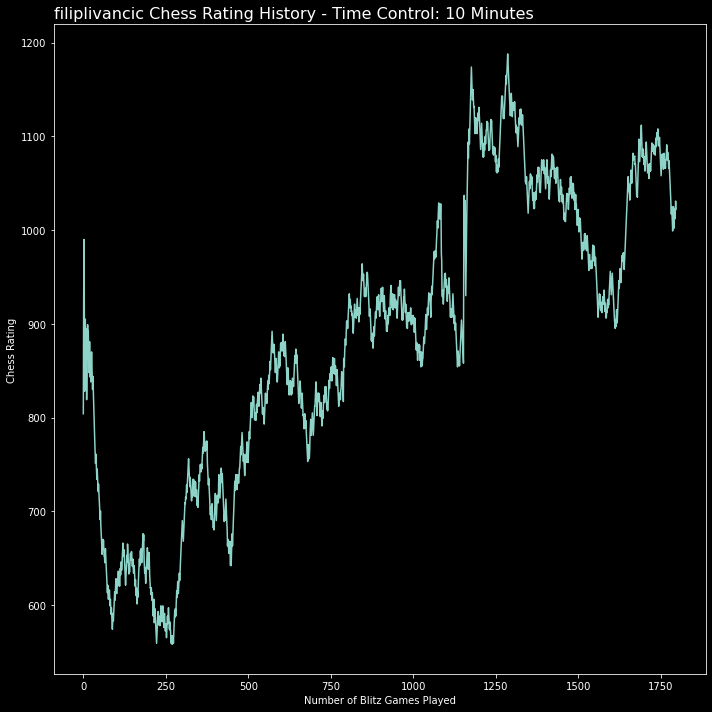

In [164]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(result_df.index,result_df['rating'])
ax.set_title(f'{player} Chess Rating History - Time Control: 10 Minutes',loc='left',fontsize=16)
ax.set_xlabel('Number of Blitz Games Played', fontsize = 10)
ax.set_ylabel('Chess Rating', fontsize=10)
plt.tight_layout()